In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def fractal_dimension(Z, threshold=50):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [3]:
# Z = (rgb2gray(imageio.imread('3.png')) < 50)

# byteImgIO = io.BytesIO()
# byteImg = Image.fromarray(Z)
# byteImg = byteImg.convert("L")
# byteImg.save(byteImgIO, "PNG")
# byteImgIO.seek(0)
# byteImg = byteImgIO.read()
# dataBytesIO = io.BytesIO(byteImg)
# Image.open(dataBytesIO)

In [4]:
A1 = [rgb2gray(imageio.imread('A1-1.PNG')), 
      rgb2gray(imageio.imread('A1-2.PNG')),
      rgb2gray(imageio.imread('A1-3.PNG')),
      rgb2gray(imageio.imread('A1-4.PNG'))]

A2 = [rgb2gray(imageio.imread('A2-1.png')), 
      rgb2gray(imageio.imread('A2-2.PNG')),
      rgb2gray(imageio.imread('A2-3.PNG'))]

B1 = [rgb2gray(imageio.imread('B1-1.PNG')), 
      rgb2gray(imageio.imread('B1-2.PNG')),
      rgb2gray(imageio.imread('B1-3.PNG'))]

B2 = [rgb2gray(imageio.imread('B2-0.PNG')), 
      rgb2gray(imageio.imread('B2-1.PNG')),
      rgb2gray(imageio.imread('B2-2.PNG')),
      rgb2gray(imageio.imread('B2-3.PNG')),
      rgb2gray(imageio.imread('B2-4.PNG'))]

C1 = [rgb2gray(imageio.imread('C1-1.PNG')), 
      rgb2gray(imageio.imread('C1-2.PNG')),
      rgb2gray(imageio.imread('C1-3.PNG')),
      rgb2gray(imageio.imread('C1-4.PNG'))]

D1 = [rgb2gray(imageio.imread('D1-1.PNG')), 
      rgb2gray(imageio.imread('D1-2.PNG')),
      rgb2gray(imageio.imread('D1-3.PNG')),
      rgb2gray(imageio.imread('D1-4.PNG'))]

In [5]:
a1_fract = []
for a1 in A1:
    a1_fract.append(fractal_dimension(a1))
a2_fract = []
for a2 in A2:
    a2_fract.append(fractal_dimension(a2))
b1_fract = []
for b1 in B1:
    b1_fract.append(fractal_dimension(b1))
b2_fract = []
for b2 in B2:
    b2_fract.append(fractal_dimension(b2))
c1_fract = []
for c1 in C1:
    c1_fract.append(fractal_dimension(c1))
d1_fract = []
for d1 in D1:
    d1_fract.append(fractal_dimension(d1))

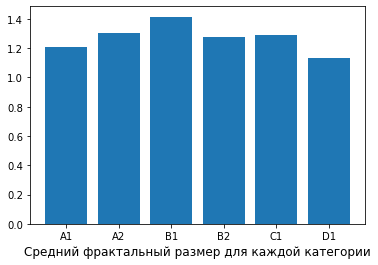

In [17]:
x_names = ["A1", "A2", "B1", "B2", "C1", "D1"]
y_frac = [np.mean(a1_fract),np.mean(a2_fract), np.mean(b1_fract), np.mean(b2_fract), np.mean(c1_fract), np.mean(d1_fract)]

plt.bar(x_names, y_frac)
 
# Custom Axis title
plt.xlabel('Средний фрактальный размер для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

In [7]:
sqr_a1 = []
for a1 in A1:
    x, y = a1.shape
    sqr_a1.append(x*y)

sqr_a2 = []
for a2 in A2:
    x, y = a2.shape
    sqr_a2.append(x*y)
    
sqr_b1 = []
for b1 in B1:
    x, y = b1.shape
    sqr_b1.append(x*y)
    
sqr_b2 = []
for b2 in B2:
    x, y = b2.shape
    sqr_b2.append(x*y)
    
sqr_c1 = []
for c1 in C1:
    x, y = c1.shape
    sqr_c1.append(x*y)

sqr_d1 = []
for d1 in D1:
    x, y = d1.shape
    sqr_d1.append(x*y)

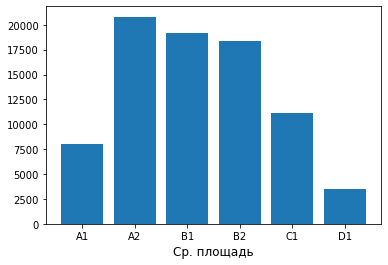

In [8]:
y_square = [np.mean(sqr_a1),np.mean(sqr_a2),np.mean(sqr_b1),np.mean(sqr_b2),np.mean(sqr_c1),np.mean(sqr_d1)]

plt.bar(x_names, y_square)
 
# Custom Axis title
plt.xlabel('Ср. площадь', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

In [9]:
df = pd.DataFrame([], columns=["Площадь", "Фрактал"], index = x_names)
df["Площадь"] = y_square
df['Фрактал'] = y_frac
df

,Площадь,Фрактал
A1,8015.000000,1.204521
A2,20807.000000,1.301222
B1,19194.666667,1.414710
B2,18317.200000,1.273627
C1,11136.250000,1.293175
D1,3479.750000,1.134932


In [15]:
data = pd.DataFrame([], columns=["Площадь", "Фрактал", "Тип"])
for a1 in A1:
    x, y = a1.shape
    data = data.append({'Площадь': x*y, "Фрактал": fractal_dimension(a1), "Тип": "А1"}, ignore_index=True)
for a2 in A2:
    x, y = a2.shape
    data = data.append({'Площадь': x*y, "Фрактал": fractal_dimension(a2), "Тип": "А2"}, ignore_index=True)
for b1 in B1:
    x, y = b1.shape
    data = data.append({'Площадь': x*y, "Фрактал": fractal_dimension(b1), "Тип": "B1"}, ignore_index=True)
for b2 in B2:
    x, y = b2.shape
    data = data.append({'Площадь': x*y, "Фрактал": fractal_dimension(b2), "Тип": "B2"}, ignore_index=True)
for c1 in C1:
    x, y = c1.shape
    data = data.append({'Площадь': x*y, "Фрактал": fractal_dimension(c1), "Тип": "C1"}, ignore_index=True)
for d1 in D1:
    x, y = d1.shape
    data = data.append({'Площадь': x*y, "Фрактал": fractal_dimension(d1), "Тип": "D1"}, ignore_index=True)

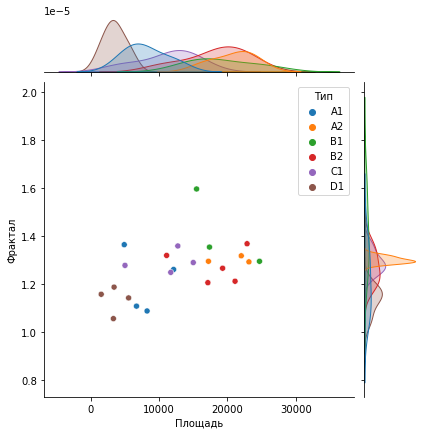

In [16]:
sns.jointplot(data=data, x="Площадь", y="Фрактал", hue="Тип")